In [0]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 4)
    return files, targets

train_files, train_targets = load_dataset('/content/drive/My Drive/bedsore_data/train')
valid_files, valid_targets = load_dataset('/content/drive/My Drive/bedsore_data/test')

In [0]:
wound_classes = [item[43:-1] for item in sorted(glob("/content/drive/My Drive/bedsore_data/train/*/"))]

In [0]:
print('There are %d total categories.' % len(wound_classes))
print(wound_classes)
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))

There are 4 total categories.
['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']
There are 125 total images.

There are 100 training images.
There are 25 validation images.


In [0]:
print(train_files)

['/content/drive/My Drive/bedsore_data/train/Stage 2/99cb2efb-7f77-461a-838a-9435c3869dd8.jpg'
 '/content/drive/My Drive/bedsore_data/train/Stage 4/2bda21f4-0ba6-4a39-ba44-2a5bb8be6fa6.JPG'
 '/content/drive/My Drive/bedsore_data/train/Stage 1/99d3ead4-1fb0-4b82-8c21-664f12450fb7.JPG'
 '/content/drive/My Drive/bedsore_data/train/Stage 2/fa1fc57f-5819-4032-8677-2dc9da912c20.jpg'
 '/content/drive/My Drive/bedsore_data/train/Stage 3/a8cf18a7-1504-469e-b4be-8c6d0e80517c.JPG'
 '/content/drive/My Drive/bedsore_data/train/Stage 4/PHOTO-2019-08-05-21-48-04.jpg'
 '/content/drive/My Drive/bedsore_data/train/Stage 2/278d95b5-3d26-430e-a0bb-6dfb325d62b6.jpg'
 '/content/drive/My Drive/bedsore_data/train/Stage 3/PHOTO-2019-08-05-21-48-05.jpg'
 '/content/drive/My Drive/bedsore_data/train/Stage 2/fa1fc57f-5819-4032-8677-2dc9da912c20(1).JPG'
 '/content/drive/My Drive/bedsore_data/train/Stage 4/PHOTO-2019-08-05-21-48-15.jpg'
 '/content/drive/My Drive/bedsore_data/train/Stage 2/e4e2d261-7ea0-4e03-9f9b-d17

In [0]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

Using TensorFlow backend.
W0807 10:27:23.083064 140551497623424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 10:27:23.132624 140551497623424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 10:27:23.158234 140551497623424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0807 10:27:23.219455 140551497623424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session inste

102858752/102853048 [==============================] - 3s 0us/step


In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, width=224, height=224):
    img = image.load_img(img_path, target_size=(width, height))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, width=224, height=224):
    list_of_tensors = [path_to_tensor(img_path, width, height) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [0]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))


In [0]:
import keras
import timeit
def show_history_graph(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show() 

class EpochTimer(keras.callbacks.Callback):
    train_start = 0
    train_end = 0
    epoch_start = 0
    epoch_end = 0
    
    def get_time(self):
        return timeit.default_timer()

    def on_train_begin(self, logs={}):
        self.train_start = self.get_time()
 
    def on_train_end(self, logs={}):
        self.train_end = self.get_time()
        print('Training took {} seconds'.format(self.train_end - self.train_start))
 
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = self.get_time()
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = self.get_time()
        print('Epoch {} took {} seconds'.format(epoch, self.epoch_end - self.epoch_start))

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True    

In [0]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 25/25 [00:00<00:00, 66.85it/s]


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint 

import matplotlib.pyplot as plt                        
%matplotlib inline

In [0]:
from keras.applications.inception_v3 import preprocess_input
from tqdm import tqdm

def paths_to_inception_tensor(img_paths, width=299, height=299):
    list_of_tensors = [preprocess_input(path_to_tensor(img_path, width, height)) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [0]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 299, 299
batch_size = 8
num_classes = 4
train_dir = '/content/drive/My Drive/bedsore_data/train'
valid_dir = '/content/drive/My Drive/bedsore_data/test'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 100 images belonging to 4 classes.
Found 25 images belonging to 4 classes.


In [0]:
import math

base_model = InceptionV3(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

output = base_model.output
output = GlobalAveragePooling2D()(output)
top_layers = Dense(4, activation='softmax')(output)

finetune_model = Model(inputs=base_model.input, outputs=top_layers)

finetune_model.summary()

finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0808 16:09:51.694911 140397658752896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 16:09:51.737023 140397658752896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 16:09:51.746840 140397658752896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 16:09:51.803805 140397658752896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0808 16:09:51.805292 1403976587

87916544/87910968 [==============================] - 1s 0us/step


W0808 16:10:07.744360 140397658752896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

W0808 16:10:14.062527 140397658752896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training Samples: 100 Validation Samples: 25 Batch Size: 8 Steps: 13
Epoch 1/20
13/13 [==============================] - 46s 4s/step - loss: 1.4116 - acc: 0.4325 - val_loss: 1.2786 - val_acc: 0.4800
Epoch 0 took 45.935896275999994 seconds
Epoch 2/20
13/13 [==============================] - 38s 3s/step - loss: 1.2831 - acc: 0.3836 - val_loss: 1.2239 - val_acc: 0.5200
Epoch 1 took 38.24814939800001 seconds
Epoch 3/20
13/13 [==============================] - 38s 3s/step - loss: 1.2329 - acc: 0.4029 - val_loss: 1.1806 - val_acc: 0.4800
Epoch 2 took 38.24353459100007 seconds
Epoch 4/20
13/13 [==============================] - 39s 3s/step - loss: 1.2005 - acc: 0.4711 - val_loss: 1.1810 - val_acc: 0.4400
Epoch 3 took 39.05970568299995 seconds
Epoch 5/20
13/13 [==============================] - 39s 3s/step - loss: 1.0982 - acc: 0.5571 - val_loss: 1.0149 - val_acc: 0.5200
Epoch 4 took 38.503175200999976 seconds
Epoch 6/20
13/13 [==============================] - 38s 3s/step - loss: 1.1106 - acc

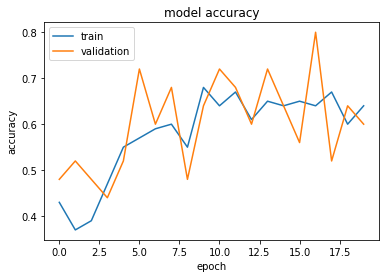

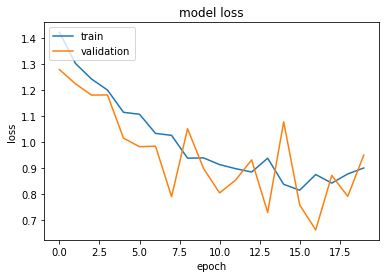

OSError: ignored

In [0]:
steps = math.ceil(train_tensors.shape[0]/batch_size)
validation_steps = math.ceil(valid_tensors.shape[0]/batch_size)
print('Training Samples: {} Validation Samples: {} Batch Size: {} Steps: {}'.format(
      train_tensors.shape[0], valid_tensors.shape[0], batch_size, steps))

epochs = 20
epochtimer = EpochTimer()

hist = finetune_model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=validation_steps,
    callbacks=[epochtimer])

show_history_graph(hist)

top_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_top')
finetune_model.save(top_model_file)



In [0]:
#for the testing of data uncomment the following 
'''
test_files, test_targets = load_dataset('<directory of test images>')
test_tensors = paths_to_tensor(test_files).astype('float32')/255
inception_test_tensors = paths_to_inception_tensor(test_files)
predictions = [np.argmax(finetune_model.predict(np.expand_dims(feature, axis=0))) for feature in inception_test_tensors]
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
'''

In [0]:
'''

#for training the entire model instead of the top layer, we'll need to uncomment this and need a lot more computational power  for completing the model efficiently and a lot more data so as to prevent overfitting. 


from keras.optimizers import SGD

NB_IV3_LAYERS_TO_FREEZE = 172
for layer in finetune_model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
    layer.trainable = False
for layer in finetune_model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
    layer.trainable = True

finetune_model.summary()

finetune_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

steps = math.ceil(train_tensors.shape[0]/batch_size)
validation_steps = math.ceil(valid_tensors.shape[0]/batch_size)
print('Training Samples: {} Validation Samples: {} Batch Size: {} Steps: {}'.format(
      train_tensors.shape[0], valid_tensors.shape[0], batch_size, steps))

epochs = 20
epochtimer = EpochTimer()

hist = finetune_model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=validation_steps,
    callbacks=[epochtimer])

show_history_graph(hist)

finetune_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_finetune')
finetune_model.save(finetune_model_file)

predictions = [np.argmax(finetune_model.predict(np.expand_dims(feature, axis=0))) for feature in inception_test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

finetune_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_finetune')
finetune_model.load_weights(finetune_model_file)

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_inception_input

def extract_InceptionV3(tensor):
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_inception_input(tensor))

def burn_classifier(img_path, selected_model, bottleneck=True, img_width=223, img_height=223):
    tensor = path_to_tensor(img_path, img_width, img_height)
    tensor = preprocess_inception_input(tensor)

    predictions = selected_model.predict(tensor)
    y_hat = np.argmax(predictions)
    return _names[y_hat]

show_history_graph(hist)
show_history_graph(hist)

'''